In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sweetviz as sv
import re
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Reading the Data

In [2]:
df = pd.read_csv("Data/combined_laptop_data.csv")

## EDA

In [3]:
# df_combined_numeric = df.select_dtypes(include=['number'])

# report = sv.analyze(df_combined_numeric)
# report.show_html('report.html')

In [4]:
df.isnull().sum().sort_values(ascending=False)

Product Name                 0
Product Price                0
Warranty Period(Months)      0
Processor Type               0
Screen Size(inch)            0
Operating System             0
product type                 0
Color                        0
Storage Capacity             0
RAM(GB)                      0
Network and Communication    0
Touch Display                0
Display Resolution           0
Battery Type                 0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.describe(include='object').T

,count,unique,top,freq
Product Name,484,274,Apple MacBook Air 13 M3,18
Processor Type,484,105,Intel Core i7-1355U (13th Gen),45
Operating System,484,14,Dos,184
product type,484,6,Laptop,186
Color,484,78,Silver,48
Storage Capacity,484,35,512GB SSD M.2,158
Network and Communication,484,38,Wi-Fi/Bluetooth,141
Touch Display,484,4,False,265
Display Resolution,484,52,1920x1080,151
Battery Type,484,59,Lithium Polymer (Li-Po),98


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Product Price,484.0,4306.944215,2469.442850,799.0,2299.0,3799.0,5999.0,11499.0
Warranty Period(Months),484.0,24.278926,4.146725,3.0,24.0,24.0,24.0,60.0
Screen Size(inch),484.0,14.827066,1.054082,8.8,14.0,15.3,15.6,17.3
RAM(GB),484.0,13.826446,7.183115,4.0,8.0,16.0,16.0,32.0


In [8]:
df.shape

(484, 14)

### outliers

## cleaning

In [9]:
def clean_storage_capacity(value):
    match = re.search(r'(\d+(\.\d+)?)\s*(TB|GB)', value, re.IGNORECASE)
    if match:
        size = float(match.group(1))
        unit = match.group(3).upper()
        if unit == 'TB':
            size *= 1024
        return size 
    return None 

def extract_storage_type(value):
    match = re.search(r'\d+(\.\d+)?\s*(TB|GB)\s*(.*)', value, re.IGNORECASE)
    if match:
        return match.group(3).strip()
    return None 

In [10]:
#storage type
df['Storage Type'] = df['Storage Capacity'].apply(extract_storage_type)

In [11]:
# Apply the cleaning function
df['Storage Capacity (GB)'] = df['Storage Capacity'].apply(clean_storage_capacity)

In [12]:
df.head()

,Product Name,Product Price,Warranty Period(Months),Processor Type,Screen Size(inch),Operating System,product type,Color,Storage Capacity,RAM(GB),Network and Communication,Touch Display,Display Resolution,Battery Type,Storage Type,Storage Capacity (GB)
0,Huawei MateBook 14,4299,24.0,Intel Core Ultra 5 125H,14.2,Windows 11 Home,Laptop,Space Grey,1 TB M.2 NVMe PCIe 4.0 SSD,16,Wi-Fi (6)/Bluetooth (5.1),Yes,2880 X 1920,Lithium Polymer (Li-Po),M.2 NVMe PCIe 4.0 SSD,1024.0
1,Apple MacBook Air 15 M3,5999,24.0,M3 8-core CPU,15.3,macOS Sequoia,Laptop,Space Grey,256 GB SSD,16,Wi-Fi/Bluetooth,No,2880 X 1864,Lithium Polymer (Li-Po),SSD,256.0
2,Apple MacBook Air 15 M3,5999,24.0,M3 8-core CPU,15.3,macOS Sonoma,Laptop,Starlight,256 GB SSD,8,Wi-Fi/Bluetooth,No,2880 X 1864,Lithium Polymer (Li-Po),SSD,256.0
3,Asus,3799,24.0,AMD Ryzen 7-8840HS,14.0,Windows 11,Laptop,Jade Black,1 TB M.2 NVMe PCIe 4.0 SSD,16,Wi-Fi/Bluetooth,No,1920 X 1200 (WUXGA),Lithium Ion (Li-Ion) - 4 Cell,M.2 NVMe PCIe 4.0 SSD,1024.0
4,Microsoft Surface 7,9699,24.0,Snapdragon X Elite 12 Core,15.0,Windows 11 Home,Laptop,Black,1 TB SSD,32,Wi-Fi (7)/Bluetooth (5.4),Yes,2496 x 1664,Lithium Ion (Li-Ion) - 6 Cell,SSD,1024.0


In [13]:
#deleted the column because i don't need it
df.drop(columns= 'Storage Capacity', inplace=True)

In [14]:
#issue in the value and tpe of the column Touch Display
df['Touch Display'].value_counts()

Touch Display
False    265
No       165
True      32
Yes       22
Name: count, dtype: int64

In [15]:
#replaced the yes and no with true and false
df['Touch Display'] = df['Touch Display'].apply(lambda x: True if str(x).lower() in ['yes', 'true'] else False)

In [16]:
#checked fr uniqe values to make ure it worked
df['Touch Display'].value_counts()

Touch Display
False    430
True      54
Name: count, dtype: int64

In [17]:
#split the displa reulatuion into the pixels height and width
def process_resolution(value):
    match = re.search(r'(\d+)\s*[xX×]\s*(\d+)', value)
    if match:
        width = int(match.group(1))
        height = int(match.group(2))
        return pd.Series([width, height])
    return pd.Series([None, None])

In [18]:
df[['Pixels Width', 'Pixels Height']] = df['Display Resolution'].apply(process_resolution)

In [19]:
df.head()

,Product Name,Product Price,Warranty Period(Months),Processor Type,Screen Size(inch),Operating System,product type,Color,RAM(GB),Network and Communication,Touch Display,Display Resolution,Battery Type,Storage Type,Storage Capacity (GB),Pixels Width,Pixels Height
0,Huawei MateBook 14,4299,24.0,Intel Core Ultra 5 125H,14.2,Windows 11 Home,Laptop,Space Grey,16,Wi-Fi (6)/Bluetooth (5.1),True,2880 X 1920,Lithium Polymer (Li-Po),M.2 NVMe PCIe 4.0 SSD,1024.0,2880,1920
1,Apple MacBook Air 15 M3,5999,24.0,M3 8-core CPU,15.3,macOS Sequoia,Laptop,Space Grey,16,Wi-Fi/Bluetooth,False,2880 X 1864,Lithium Polymer (Li-Po),SSD,256.0,2880,1864
2,Apple MacBook Air 15 M3,5999,24.0,M3 8-core CPU,15.3,macOS Sonoma,Laptop,Starlight,8,Wi-Fi/Bluetooth,False,2880 X 1864,Lithium Polymer (Li-Po),SSD,256.0,2880,1864
3,Asus,3799,24.0,AMD Ryzen 7-8840HS,14.0,Windows 11,Laptop,Jade Black,16,Wi-Fi/Bluetooth,False,1920 X 1200 (WUXGA),Lithium Ion (Li-Ion) - 4 Cell,M.2 NVMe PCIe 4.0 SSD,1024.0,1920,1200
4,Microsoft Surface 7,9699,24.0,Snapdragon X Elite 12 Core,15.0,Windows 11 Home,Laptop,Black,32,Wi-Fi (7)/Bluetooth (5.4),True,2496 x 1664,Lithium Ion (Li-Ion) - 6 Cell,SSD,1024.0,2496,1664


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Product Name               484 non-null    object 
 1   Product Price              484 non-null    int64  
 2   Warranty Period(Months)    484 non-null    float64
 3   Processor Type             484 non-null    object 
 4   Screen Size(inch)          484 non-null    float64
 5   Operating System           484 non-null    object 
 6   product type               484 non-null    object 
 7   Color                      484 non-null    object 
 8   RAM(GB)                    484 non-null    int64  
 9   Network and Communication  484 non-null    object 
 10  Touch Display              484 non-null    bool   
 11  Display Resolution         484 non-null    object 
 12  Battery Type               484 non-null    object 
 13  Storage Type               484 non-null    object 

In [21]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
columns_to_encode = [
    'Product Name',
    'Processor Type', 
    'Operating System', 
    'Color', 
    'Display Resolution', 
    'Battery Type', 
    'Storage Type'
]

# Create encoded columns dynamically
for col in columns_to_encode:
    encoded_col = f"{col.replace(' ', '_')}_encoded"
    df[encoded_col] = label_encoder.fit_transform(df[col])

In [22]:
df.drop(columns=[
    'Product Name',
    'Processor Type',
    'Operating System',
    'Color',
    'Display Resolution',
    'Battery Type',
    'Storage Type',], inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Product Price               484 non-null    int64  
 1   Warranty Period(Months)     484 non-null    float64
 2   Screen Size(inch)           484 non-null    float64
 3   product type                484 non-null    object 
 4   RAM(GB)                     484 non-null    int64  
 5   Network and Communication   484 non-null    object 
 6   Touch Display               484 non-null    bool   
 7   Storage Capacity (GB)       484 non-null    float64
 8   Pixels Width                484 non-null    int64  
 9   Pixels Height               484 non-null    int64  
 10  Product_Name_encoded        484 non-null    int32  
 11  Processor_Type_encoded      484 non-null    int32  
 12  Operating_System_encoded    484 non-null    int32  
 13  Color_encoded               484 non

## visualization

Text(0.5, 1.0, 'visualization of raw data')

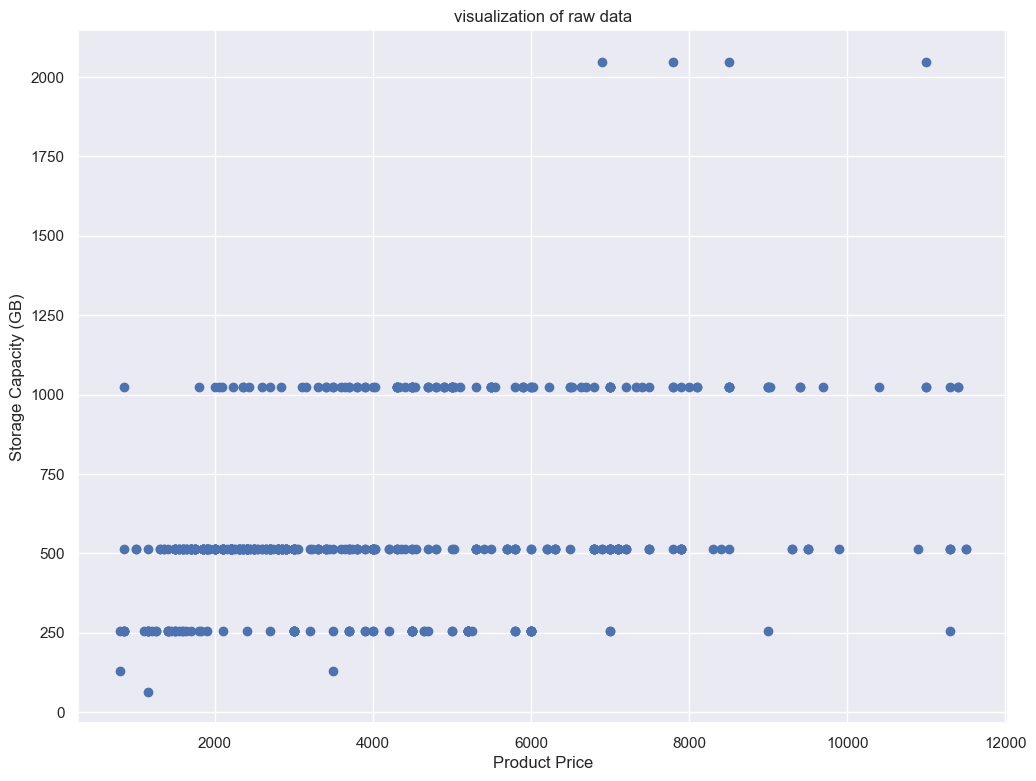

In [24]:
plt.figure(figsize = (12, 9))
plt.scatter(df['Product Price'],df['Storage Capacity (GB)'])
plt.xlabel('Product Price')
plt.ylabel('Storage Capacity (GB)')
plt.title('visualization of raw data')

### Relevnce 

In [25]:
df.head()

,Product Price,Warranty Period(Months),Screen Size(inch),product type,RAM(GB),Network and Communication,Touch Display,Storage Capacity (GB),Pixels Width,Pixels Height,Product_Name_encoded,Processor_Type_encoded,Operating_System_encoded,Color_encoded,Display_Resolution_encoded,Battery_Type_encoded,Storage_Type_encoded
0,4299,24.0,14.2,Laptop,16,Wi-Fi (6)/Bluetooth (5.1),True,1024.0,2880,1920,180,26,6,64,29,52,4
1,5999,24.0,15.3,Laptop,16,Wi-Fi/Bluetooth,False,256.0,2880,1864,44,91,11,64,28,52,13
2,5999,24.0,15.3,Laptop,8,Wi-Fi/Bluetooth,False,256.0,2880,1864,44,91,12,66,28,52,13
3,3799,24.0,14.0,Laptop,16,Wi-Fi/Bluetooth,False,1024.0,1920,1200,59,15,4,31,5,44,4
4,9699,24.0,15.0,Laptop,32,Wi-Fi (7)/Bluetooth (5.4),True,1024.0,2496,1664,237,101,6,5,17,45,13


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Product Price               484 non-null    int64  
 1   Warranty Period(Months)     484 non-null    float64
 2   Screen Size(inch)           484 non-null    float64
 3   product type                484 non-null    object 
 4   RAM(GB)                     484 non-null    int64  
 5   Network and Communication   484 non-null    object 
 6   Touch Display               484 non-null    bool   
 7   Storage Capacity (GB)       484 non-null    float64
 8   Pixels Width                484 non-null    int64  
 9   Pixels Height               484 non-null    int64  
 10  Product_Name_encoded        484 non-null    int32  
 11  Processor_Type_encoded      484 non-null    int32  
 12  Operating_System_encoded    484 non-null    int32  
 13  Color_encoded               484 non

In [27]:

df.drop(columns = ['product type',
                   'Network and Communication',
                   'Product_Name_encoded',
                   'Touch Display',
                   'Warranty Period(Months)',
                   'Color_encoded',
                   'Operating_System_encoded',
                   'Display_Resolution_encoded',
                   'Storage_Type_encoded',
                   'Battery_Type_encoded'
                  ], inplace = True)

In [49]:
df.columns

Index(['Product Price', 'Screen Size(inch)', 'RAM(GB)',
       'Storage Capacity (GB)', 'Pixels Width', 'Pixels Height',
       'Processor_Type_encoded'],
      dtype='object')

## Standardization

In [28]:
scaler = StandardScaler()
df_std = scaler.fit_transform(df)

## PCA

In [29]:
# Assuming df_std is already preprocessed and standardized
# Perform PCA
pca = PCA()
pca.fit(df_std)

PCA()

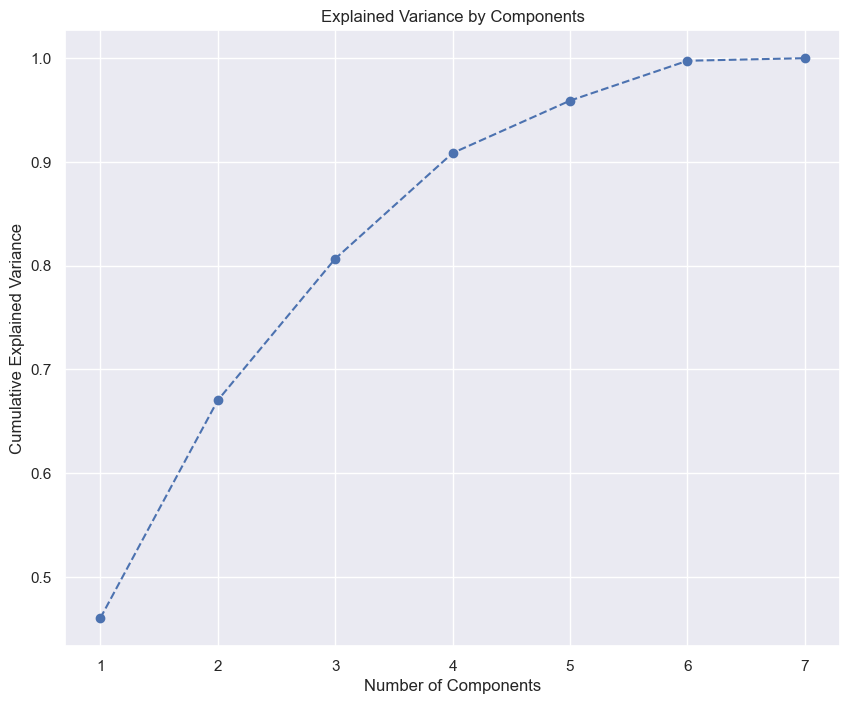

In [30]:
# Plot cumulative explained variance
plt.figure(figsize=(10, 8))
n_components = len(pca.explained_variance_ratio_)
plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_.cumsum(), 
         marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

In [32]:
# Fit PCA with a chosen number of components
pca = PCA(n_components= 4)
scores_pca = pca.fit_transform(df_std)

## k-means clustering with PCA

In [33]:
# Perform K-means clustering and determine optimal clusters using the elbow method
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=800, n_init=50, random_state=0)
    kmeans.fit(df_std)
    wcss.append(kmeans.inertia_)

  File "C:\Users\arwa1\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


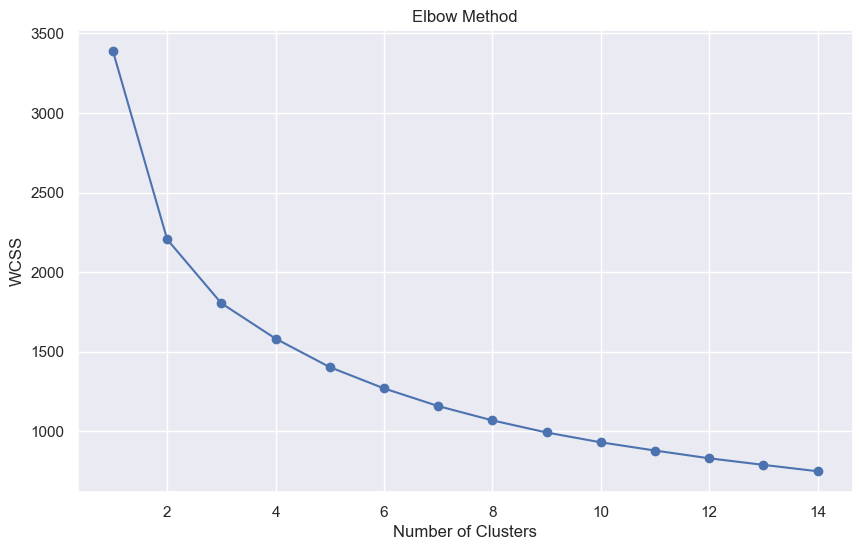

In [34]:
# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [35]:
# Fit K-means with the optimal number of clusters (e.g., 3)
kmeans_pca = KMeans(n_clusters=3, init='k-means++', max_iter=800, n_init=50, random_state=0)
kmeans_pca.fit(scores_pca)

KMeans(max_iter=800, n_clusters=3, n_init=50, random_state=0)

In [36]:
# Concatenate the original standardized data with the PCA scores
df_segm_pca_kmeans = pd.concat([df.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)

In [37]:
# Assign proper column names
pca_columns = [f'Component {i + 1}' for i in range(scores_pca.shape[1])]
df_segm_pca_kmeans.columns = list(df.columns) + pca_columns

In [38]:
# Add the cluster labels to the DataFrame
df_segm_pca_kmeans['Segment kmeans PCA'] = kmeans_pca.labels_

In [39]:
# Display the resulting DataFrame
df_segm_pca_kmeans.head()

,Product Price,Screen Size(inch),RAM(GB),Storage Capacity (GB),Pixels Width,Pixels Height,Processor_Type_encoded,Component 1,Component 2,Component 3,Component 4,Segment kmeans PCA
0,4299,14.2,16,1024.0,2880,1920,26,1.747702,-0.160484,1.944432,-0.078962,2
1,5999,15.3,16,256.0,2880,1864,91,1.638485,-0.875593,-1.379796,-1.091024,1
2,5999,15.3,8,256.0,2880,1864,91,1.240713,-1.415473,-1.477162,-1.383309,1
3,3799,14.0,16,1024.0,1920,1200,15,-0.381258,0.759480,2.042668,1.040489,0
4,9699,15.0,32,1024.0,2496,1664,101,3.298064,2.011718,-0.985019,0.562053,2


In [42]:
df_segm_pca_kmeans['Segment kmeans PCA'].unique()

array([2, 1, 0])

In [43]:
df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment kmeans PCA'].map({
    0 : 'first',
    1 : 'second',
    2 : 'third'
})


In [44]:
df_segm_pca_kmeans.head()

,Product Price,Screen Size(inch),RAM(GB),Storage Capacity (GB),Pixels Width,Pixels Height,Processor_Type_encoded,Component 1,Component 2,Component 3,Component 4,Segment kmeans PCA,Segment
0,4299,14.2,16,1024.0,2880,1920,26,1.747702,-0.160484,1.944432,-0.078962,2,third
1,5999,15.3,16,256.0,2880,1864,91,1.638485,-0.875593,-1.379796,-1.091024,1,second
2,5999,15.3,8,256.0,2880,1864,91,1.240713,-1.415473,-1.477162,-1.383309,1,second
3,3799,14.0,16,1024.0,1920,1200,15,-0.381258,0.759480,2.042668,1.040489,0,first
4,9699,15.0,32,1024.0,2496,1664,101,3.298064,2.011718,-0.985019,0.562053,2,third


## Visualize the clusters


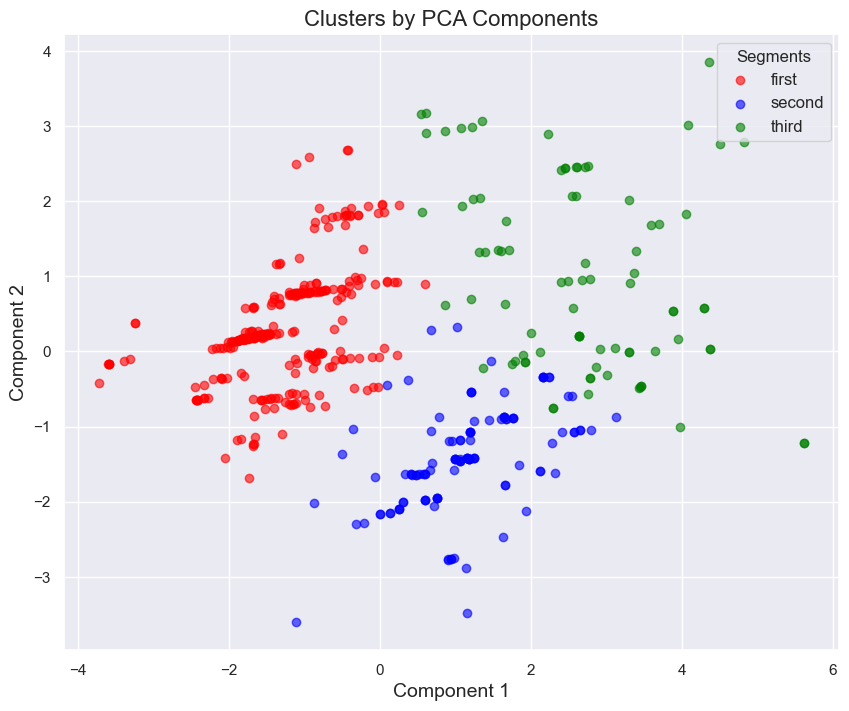

In [45]:
# Visualize the clusters with respect to the first two PCA components
plt.figure(figsize=(10, 8))

# Define colors for the three clusters
colors = ['red', 'blue', 'green']

# Create a scatter plot for each cluster
for segment, color in zip(['first', 'second', 'third'], colors):
    subset = df_segm_pca_kmeans[df_segm_pca_kmeans['Segment'] == segment]
    plt.scatter(subset['Component 1'], subset['Component 2'], label=segment, alpha=0.6, color=color)

# Add labels, legend, and grid
plt.title('Clusters by PCA Components', fontsize=16)
plt.xlabel('Component 1', fontsize=14)
plt.ylabel('Component 2', fontsize=14)
plt.legend(title='Segments', fontsize=12)
plt.grid(True)
plt.show()


In [46]:
df_1 =df_segm_pca_kmeans[df_segm_pca_kmeans['Segment']=='first']

In [47]:
df_2 = df_segm_pca_kmeans[df_segm_pca_kmeans['Segment']=='second']

In [48]:
df_3 = df_segm_pca_kmeans[df_segm_pca_kmeans['Segment']=='third']

In [50]:
report = sv.analyze(df_1)
report.show_html('report.html')

                                             |                                             | [  0%]   00:00 ->…

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [51]:
report = sv.analyze(df_2)
report.show_html('report.html')

                                             |                                             | [  0%]   00:00 ->…

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [52]:
report = sv.analyze(df_3)
report.show_html('report.html')

                                             |                                             | [  0%]   00:00 ->…

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
